# guiding question:

What if we used a forward model to get exchange between substrate pools - and then calculated the probabilities for EVERY N2O production process based on the proportions of the substrates for that process? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and likewise for each of the other isotopomers as well.

# next:

- Error estimates with randomly-selected initial guess
- Post-processing: multiply rates by in-situ nutrient concentrations instead of added tracer+carrier concentrations?
- is there a better way to calculate cost? this feels a bit arbitrary...
- get the model running on Sherlock
- model v4 - instead of hybrid process combining NH4+ and NO2-, it combines NH2OH and NO2-

# initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
#from collections import namedtuple

# use for plotting interpolations of measured incubation data
#import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [89]:
### KEYWORDS ###
stn = "PS1"
ft = "Interface"
bgckey = stn+ft

### INITIALIZATION ###

gridded_dataNH4, bgcNH4, isos, trNH4, params = sc.initialize(station=stn,
                                      feature=ft,
                                      tracer="NH4+")
gridded_dataNO2, bgcNO2, isos, trNO2, params = sc.initialize(station=stn,
                                      feature=ft,
                                      tracer="NO2-")
gridded_dataNO3, bgcNO3, isos, trNO3, params = sc.initialize(station=stn,
                                      feature=ft,
                                      tracer="NO3-")

### INITIAL GUESS FOR OPTIMIZATION ###
guess = sc.x0(station=stn, feature=ft, key=bgckey)

[kestimateNH4, kestimateNO, kestimateNO2, kestimateNO3, kestimate_hybrid1,
 kestimate_hybrid2, kestimate_hybrid3, kestimate_hybrid4,
kestimate_hybrid5, kestimate_hybrid6] = guess

estimated k for N2O production from NH4+: 0.0
estimated k for N2O production from NO3-: 1.0876182197431473e-09
estimated k for N2O production from NO2-: 2.7630236588163697e-10
estimated k for N2O production from NO: 3.5858402342386703e-06
estimated k for hybrid pathway #1 from NH4+ & NO2-: 8.834915380773962e-09
estimated k for hybrid pathway #2 from NH4+ & NO2-: 1.8262957017869628e-08
estimated k for hybrid pathway #1 from NH2OH & NO: 6.859187387806156e-05
estimated k for hybrid pathway #2 from NH2OH & NO: 0.00013013983994311675
estimated k for hybrid pathway #1 from NH2OH & NO2-: 4.4047632388818095e-07
estimated k for hybrid pathway #2 from NH2OH & NO2-: 9.105237391329081e-07


In [90]:
bgcNH4.kN2OCONS

0.019233554

# test models

In [91]:
x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid5, kestimate_hybrid6]

tracers = sc.modelv4(x, bgcNH4, isos, trNH4, params)

print(sc.costfxn(trainingdata = gridded_dataNH4,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([0,1000,1000,1000])))

13.315441863109896


In [92]:
x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid5, kestimate_hybrid6]

tracers = sc.modelv4(x, bgcNO2, isos, trNO2, params)

print(sc.costfxn(trainingdata = gridded_dataNO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([0,1000,1000,1000])))

21.355334603893027


In [93]:
x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid5, kestimate_hybrid6]

tracers = sc.modelv4(x, bgcNO3, isos, trNO3, params)

print(sc.costfxn(trainingdata = gridded_dataNO3,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([0,1000,1000,1000])))

7.821813348451232


# optimization

In [106]:
def objective(x): #, bgc, isos, tracers, modelparams):
    
    tracersNH4 = sc.modelv4(x, bgcNH4, isos, trNH4, params)
    
    costNH4 = sc.costfxn(trainingdata = gridded_dataNH4,
                modeled_44 = tracersNH4.n2o_44,
                modeled_45a = tracersNH4.n2o_45a,
                modeled_45b = tracersNH4.n2o_45b,
                modeled_46 = tracersNH4.n2o_46,
                weights = np.array([0,1000,1000,1000]))
    
    tracersNO2 = sc.modelv4(x, bgcNO2, isos, trNO2, params)
    
    costNO2 = sc.costfxn(trainingdata = gridded_dataNO2,
                modeled_44 = tracersNO2.n2o_44,
                modeled_45a = tracersNO2.n2o_45a,
                modeled_45b = tracersNO2.n2o_45b,
                modeled_46 = tracersNO2.n2o_46,
                weights = np.array([0,1000,1000,1000]))
    
    tracersNO3 = sc.modelv4(x, bgcNO3, isos, trNO3, params)
    
    costNO3 = sc.costfxn(trainingdata = gridded_dataNO3,
                modeled_44 = tracersNO3.n2o_44,
                modeled_45a = tracersNO3.n2o_45a,
                modeled_45b = tracersNO3.n2o_45b,
                modeled_46 = tracersNO3.n2o_46,
                weights = np.array([0,1000,1000,1000]))
    
    cost = costNH4 + costNO2 + costNO3
    
    print(cost)
    
    return cost

In [107]:
#x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid1, kestimate_hybrid2] # for modelv1

#x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid3, kestimate_hybrid4] # for modelv2

#x = [kestimateNH4, kestimateNO, kestimateNO3, kestimate_hybrid3, kestimate_hybrid4] # for modelv3

x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid5, kestimate_hybrid6] # for modelv4

objective(x)

154.2946443280167


154.2946443280167

In [108]:
xguess = x

xguess

[0.0,
 2.7630236588163697e-10,
 1.0876182197431473e-09,
 4.4047632388818095e-07,
 9.105237391329081e-07]

In [109]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selected x0
#result = minimize(objective, x, args = (bgc, isos, tr, modelparams), method='nelder-mead', bounds=bnds)
result = minimize(objective, x, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)#, bgc, isos, tr, params)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

154.2946443280167
179939.76254868557
153.29685210242013
153.16347934186882
154.0078876463996
153.64397619832695
153.04224762965117
152.43052626973355
152.30948274364707
151.35841358307425
151.55921076174747
151.1656818152366
150.16956670624535
150.49342918280763
149.1444532660101
147.25745490359463
148.2424207523165
147.78111578414828
147.1592123388638
146.25960092275827
145.17185312358822
142.9201603889656
143.2603503577624
142.7902313448495
140.66888146903534
140.43224024272467
137.38222758820598
138.80258289422142
135.22322267412858
130.59049358633007
132.8149863275211
130.5946448682747
127.73249494774207
122.26684133609518
123.16292495057786
120.12964735230136
122.72914426943238
119.16094960410778
120.89372621610582
116.26730847934641
120.53215727212779
126.29392515381886
117.45380811599719
120.88581940786551
122.03391793265519
117.94668170036675
119.74718201873102
116.02463584677217
118.1106999340804
123.94921960598579
117.81022628163021
117.65602470270667
115.76996193074018
116.0

In [46]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(5)*(r_max - r_min)

pt

array([3.81533134e-09, 2.25129744e-08, 1.12618614e-09, 0.00000000e+00,
       2.73809851e-06])

In [48]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, x, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

313.1611101731623
313.1430247066242
306.73729937718616
312.21629169942827
2557.59229599784
313.1280255681794
310.1769915420925
308.9893468639223
307.3579286837992
305.0882217627359
301.1329623009432
301.6245744020614
300.20966779971474
295.3594754915209
295.98606089821345
293.1294587539426
286.3723585220899
285.7382487690084
276.0092872379338
280.405004413184
273.4260499642149
261.9351340930394
264.79736284162874
255.64537314340075
244.51742758577552
246.93034494568533
243.76728396973772
245.82270748466706
243.24513031578374
257.80784488679177
244.4696619776654
250.91033295174367
243.41593443271637
250.19071175577724
243.13559914424695
246.04466461898582
242.7053059401453
245.23359488939718
242.7634645545429
243.7370328544818
242.63078598340388
244.54052059406928
242.45477973582177
241.50534774996837
241.3844653595329
243.4953591462151
242.12742572851556
241.8480950665216
240.79000328176087
240.48166147742225
241.33546013698069
242.44863798154503
241.35406205554563
239.45376993870283
2

NameError: name 'bgc' is not defined

In [110]:
objective(result.x)#, bgc, isos, tr, modelparams)

93.39981845453042


93.39981845453042

In [111]:
result.x

array([0.00000000e+00, 9.81405095e-10, 1.26369640e-09, 3.55687357e-11,
       2.33413187e-06])

# post-processing

In [112]:
tracersNH4 = sc.modelv4(result.x, bgcNH4, isos, trNH4, params)
tracersNO2 = sc.modelv4(result.x, bgcNO2, isos, trNO2, params)
tracersNO3 = sc.modelv4(result.x, bgcNO3, isos, trNO3, params)

outputNH4 = sc.postprocess(bgcNH4, isos, tracersNH4, result.x, model="modelv4")
outputNO2 = sc.postprocess(bgcNO2, isos, tracersNO2, result.x, model="modelv4")
outputNO3 = sc.postprocess(bgcNO3, isos, tracersNO3, result.x, model="modelv4")

saveout = np.array([outputNH4[['nitrification', 'denitno2', 'denitno3', 'hybrid1', 'hybrid2']].mean(),
            outputNO2[['nitrification', 'denitno2', 'denitno3', 'hybrid1', 'hybrid2']].mean(),
            outputNO3[['nitrification', 'denitno2', 'denitno3', 'hybrid1', 'hybrid2']].mean()])

saveout = saveout.mean(axis=0)

saveout = pd.DataFrame([saveout]).rename(columns = {0:"Nitrification (nM/day)",
                                   1:"Denit from NO2- (nM/day)",
                                          2:"Denit from NO3- (nM/day)",
                                          3:"Hybrid1 (nM/day)",
                                          4:"Hybrid2 (nM/day)"})

saveout["Station"] = stn
saveout["Feature"] = ft
saveout["Key"] = bgckey
saveout["cost"] = objective(result.x)
saveout = saveout.set_index("Key")
modeloutput = pd.read_excel("scripts/data/00_modelv4output.xlsx",
                           index_col="Key")
modeloutput = modeloutput.append(saveout)
modeloutput = modeloutput.drop_duplicates()
modeloutput.to_excel("scripts/data/00_modelv4output.xlsx")

Nit. (nM/day): 0.0
Denit. from NO2- (nM/day): 0.0009836618435358725
Denit. from NO3- (nM/day): 1.1041665624361003
Hybrid 1 (nM/day): 3.590866089612779e-07
Hybrid 2 (nM/day): 0.023564388201624223
Nit. (nM/day): 0.0
Denit. from NO2- (nM/day): 0.022314590126645436
Denit. from NO3- (nM/day): 1.1041665624361003
Hybrid 1 (nM/day): 1.7028222906817787e-06
Hybrid 2 (nM/day): 0.11174453319792671
Nit. (nM/day): 0.0
Denit. from NO2- (nM/day): 0.0009836674754159528
Denit. from NO3- (nM/day): 1.180135448929736
Hybrid 1 (nM/day): 3.591637996239169e-07
Hybrid 2 (nM/day): 0.023569453694724147
93.39981845453042


In [113]:
print(np.mean(kestimateNO3*(outputNO3['[NO3-]_nM']**2) + tracersNO3.n2o_46[0]*bgcNO3.kN2OCONS))

print(np.mean(result.x[2]*(outputNO3['[NO3-]_nM']**2)))

1.0211377882894597
1.180135448929736


In [114]:
print(outputNH4['check_mass_conservation'].min())
print(outputNH4['check_mass_conservation'].max())

31231.450523175023
31232.067253645004


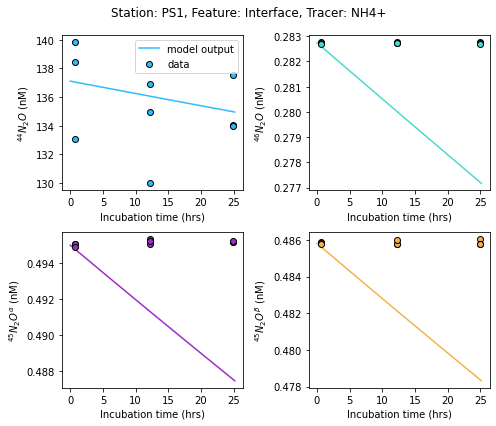

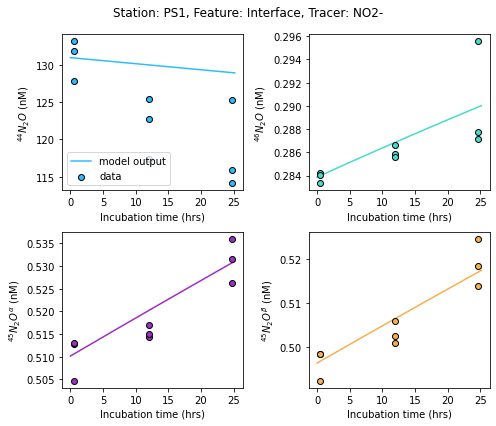

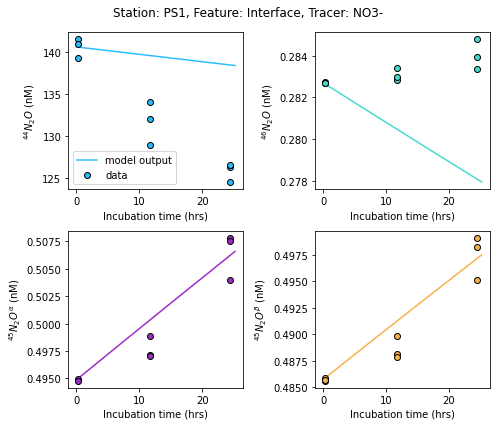

In [115]:
inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv')

sc.scatter_plot(data=inputdata, station=stn, feature=ft, tracer="NH4+",
             modeloutput=outputNH4, filename=f"Figures/{stn}{ft}NH4+modelv4.pdf")

sc.scatter_plot(data=inputdata, station=stn, feature=ft, tracer="NO2-",
             modeloutput=outputNO2, filename=f"Figures/{stn}{ft}NO2-modelv4.pdf")

sc.scatter_plot(data=inputdata, station=stn, feature=ft, tracer="NO3-",
             modeloutput=outputNO3, filename=f"Figures/{stn}{ft}NO3-modelv4.pdf")


<AxesSubplot:>

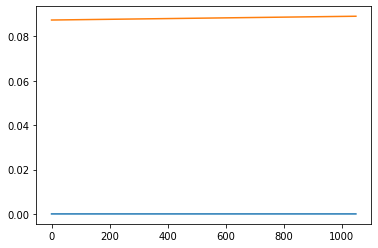

In [40]:
outputNO2.hybrid1.plot()
outputNO2.hybrid2.plot()

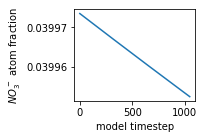

In [118]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(outputNO3[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
#plt.savefig("figures/no3-atomfraction.pdf")

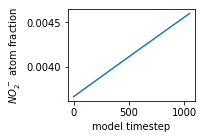

In [119]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(outputNO3[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
#plt.savefig("figures/no2-atomfraction.pdf")

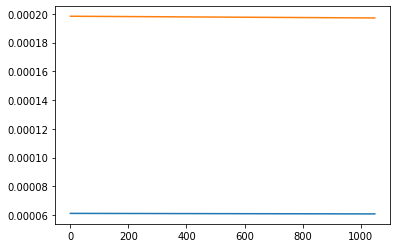

In [63]:
plt.plot(outputNH4['hybrid1'])
plt.plot(outputNH4['hybrid2'])

In [23]:
sc.binomial(0.99, 0.03)

(0.029699999999999997,
 0.9602999999999999,
 0.00030000000000000024,
 0.009700000000000009)

In [24]:
sc.binomial_stoichiometry(0.99, 0.03)

(0.3465, 0.6434999999999998, 0.0035000000000000027, 0.006500000000000005)